In [5]:

import matplotlib.gridspec as gridspec
from matplotlib import style
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import cKDTree
from joblib import Parallel, delayed
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
from scipy.stats import gaussian_kde
import sys
sys.path.append('/home/guozx/soft/')
import sphviewer
import readgadget as rg 

ImportError: /home/guozx/anaconda3/lib/python3.12/lib-dynload/../../libssl.so.3: version `OPENSSL_3.2.0' not found (required by /home/guozx/anaconda3/lib/python3.12/site-packages/h5py/../../.././libcurl.so.4)

In [10]:
def cent_h(X):

    
    # 构建 KD 树
    tree = cKDTree(X)  

    # 为每个点查询最近的30个邻居点
    dist, ind = tree.query(X, k=100)  

    # 计算局部密度
    epsilon = 1e-5
    rho = 1 / (dist + epsilon).sum(axis=1)

    # 密度最大值点的索引
    densest_idx = np.argmax(rho)

    return X[densest_idx]

def read(runpath ,i):
    snapfname = runpath + 'snapshot_' + str(i).zfill(3) 
    phalo = rg.readsnap(snapfname, 'pos', 'dm')
    idhalo = rg.readsnap(snapfname, 'pid', 'dm')
    pdisk = rg.readsnap(snapfname, 'pos', 'disk')
    pbulge = rg.readsnap(snapfname, 'pos', 'bulge')
    idisk = rg.readsnap(snapfname, 'pid', 'disk')
    ibulge = rg.readsnap(snapfname, 'pid', 'bulge')
    vbulge = rg.readsnap(snapfname, 'vel', 'bulge')
    
    '''pmw_halo = phalo[(idhalo > 0) & (idhalo <= 1000000)]
    pm31_halo = phalo[(idhalo > 1000000) & (idhalo <= 2500000)]
    pmw_disk = pdisk[(idisk > 2500000) & (idisk <= 3200000)]
    pmw_bulge = pbulge[(ibulge > 4400000) & (ibulge <= 4500000)]
    pm31_disk = pdisk[(idisk > 3200000) & (idisk <= 4400000)]    
    pm31_bulge = pbulge[(ibulge > 4500000) & (ibulge <= 4690000)]
    vm31_bulge = vbulge[(ibulge > 4500000) & (ibulge <= 4690000)]'''
    pmw_halo = phalo[(idhalo > 0) & (idhalo <= 500000)]
    pm31_halo = phalo[(idhalo > 500000) & (idhalo <= 1250000)]
    pmw_disk = pdisk[(idisk > 1250000) & (idisk <= 1600000)]
    pmw_bulge = pbulge[(ibulge > 2200000) & (ibulge <= 2250000)]
    pm31_disk = pdisk[(idisk > 1600000) & (idisk <= 2200000)]    
    pm31_bulge = pbulge[(ibulge > 2250000) & (ibulge <= 2345000)]
    vm31_bulge = vbulge[(ibulge > 2250000) & (ibulge <= 2345000)]
    cent_mw = cent_h(pmw_bulge)
    print(cent_mw)
    cent_m31 = cent_h(pm31_bulge)
    cent = 0.6 * cent_m31 + 0.4 * cent_mw
    #pstar = pm31_bulge - cent_m31.reshape((1, 3))
    #rr2 = ((pstar**2).sum(-1))**0.5
    #vgal2 = np.mean(vm31_bulge[rr2 <= 5., :], axis=0)
    #print(vgal2)
    r= cent_m31-cent_mw
    rmw = cent_mw-cent
    rm31 = cent_m31-cent
    posMW = np.r_[pmw_disk-cent]    
    posM31 = np.r_[pm31_disk-cent]
    posdm_MW = np.r_[pmw_halo-cent]
    posdm_M31 = np.r_[pm31_halo-cent]
    return posdm_MW,posdm_M31,posMW, posM31,rmw,rm31


def create_density_map(pos, xlim, ylim, bins=100):
    H, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=bins, range=[xlim, ylim])
    H = H.T  # Transpose to match the orientation of the plot
    return H, xedges, yedges

In [11]:


runpath = '/home/guozx/M31/Output/low_res/DR3/'
i = 0
posdm_MW,posdm_M31,posMW, posM31,rmw,rm31 = read(runpath, i)


Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[0.00071697 0.00290847 0.00360545]


In [19]:
r0 = np.array([-375.1316149740847,605.5277209737903,-278.83597703631733]) 
v0 = np.array([37.53564320437491,-114.3816276001235,15.117831344570334])#dr3
x_COM = r0/np.linalg.norm(r0)
z_COM = -np.cross(r0,v0)/np.linalg.norm(np.cross(r0,v0))
y_COM = -np.cross(x_COM,z_COM)
print(x_COM,y_COM,z_COM)
#坐标变化的矩阵
A = np.array([x_COM,y_COM,z_COM])
A = A.T
frames = np.arange(0, 430, 10)
# 并行读取数据
results = Parallel(n_jobs=20)(delayed(read)(runpath, i) for i in frames)
rmw = np.array([result[4] for result in results])
rm31 = np.array([result[5] for result in results])
rCOM_mw = np.dot(rmw, A)
rCOM_m31 = np.dot(rm31, A)

[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
Returning DM    Positions
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DM    Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning DISK  Positions
Returning DM    Particle IDsReturning DM    PositionsReturning DISK  Positions


Returning BULGE Velocities
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Positions
Returning BULGE Particle IDs
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Velocities
Returning DISK  Particle IDs
Returning BULGE Positions
Returning BULGE Particle IDs
Returning DISK  Particle IDs
Returning DM    Positions
Returning BULGE Particle IDs
Returning DM    Particle IDs
Returning 

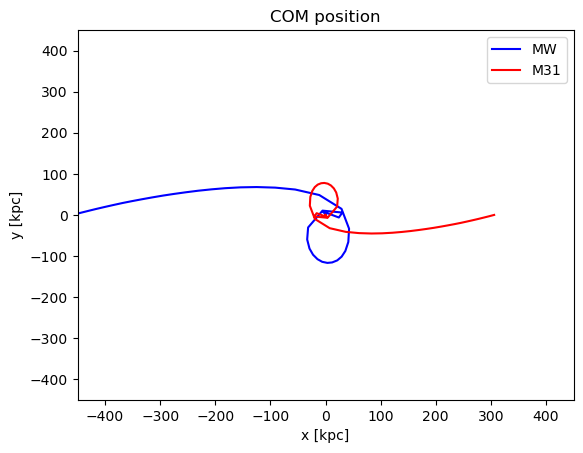

In [21]:

plt.plot(rCOM_mw[:, 0], rCOM_mw[:, 1], 'b-', label='MW')
plt.plot(rCOM_m31[:, 0], rCOM_m31[:, 1], 'r-', label='M31')
plt.legend()
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('COM position')
plt.xlim(-450, 450)
plt.ylim(-450, 450)

plt.show()

Returning DM    Positions
Returning DM    Particle IDs
Returning DM    PositionsReturning DM    Positions

Returning DISK  Positions
Returning DM    Positions
Returning BULGE Positions
Returning DM    PositionsReturning DM    Positions

Returning DISK  Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Particle IDsReturning BULGE Particle IDs

Returning DM    Particle IDs
Returning BULGE Velocities
Returning DM    Particle IDs
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning DISK  Positions
Returning BULGE Positions
Returning BULGE PositionsReturning BULGE Positions

Returning DISK  Particle IDs
Returning DISK  PositionsReturning DISK  Positions

Returning DISK  Positions
Returning DM    Positions
Returning BULGE Particle IDs
Returning DISK  Particle IDs
Returning DISK  Particle IDs
Returning BULGE PositionsReturning BULGE Positi

(0.0, 800.0)

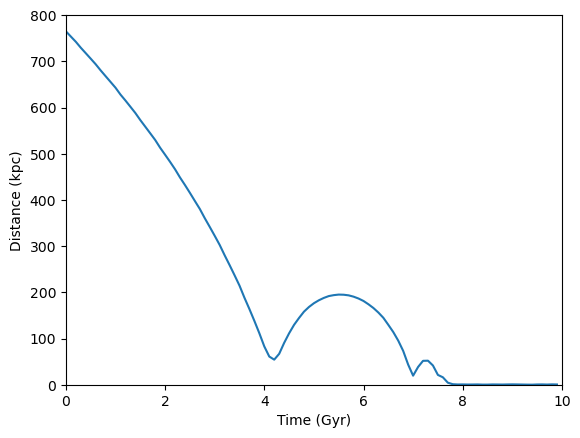

In [23]:
frames = np.arange(0, 500, 5)
# 并行读取数据
results = Parallel(n_jobs=20)(delayed(read)(runpath, i) for i in frames)
r_values = [np.linalg.norm(result[4]-result[5]) for result in results]
time_values = frames/50
np.save('r_values.npz', r_values)
plt.plot(time_values, r_values)
plt.xlabel('Time (Gyr)')
plt.ylabel('Distance (kpc)')
plt.xlim(0, 10)
plt.ylim(0, 800)

In [1]:

fig = plt.figure()
ax = fig.add_subplot(111)   
#ax.scatter(posM31[:,0], posM31[:,1], s=0.0, c='r', label='M31')
H, xedges, yedges = create_density_map(np.r_[posdm_MW[:, [0, 1]],posdm_M31[:, [0, 1]]], [-500, 500], [-500, 500])
ax.scatter(rm31[0], rm31[1], s=100, c='r', label='M31')
ax.scatter(rmw[0], rmw[1], s=100, c='b', label='MW')
cs=ax.contour(xedges[:-1], yedges[:-1], np.log10(H), cmap='jet', levels= np.linspace(1.5, 3.5, 10))
#ax.contour(xedges_m31[:-1], yedges_m31[:-1], np.log10(H_M31), cmap='Reds',levels= np.linspace(1.5, 3.5, 10))
ax.clabel(cs, inline=True, fontsize=10)
ax.set_xlabel('x[kpc]')
ax.set_ylabel('y[kpc]')
ax.legend()
ax.set_xlim(-500, 500)
ax.set_ylim(-500, 500)
ax.set_title('t=8')
ax.legend()
plt.show()
print(posMW[:, [0, 1]].shape)

NameError: name 'plt' is not defined

<a list of 6 text.Text objects>

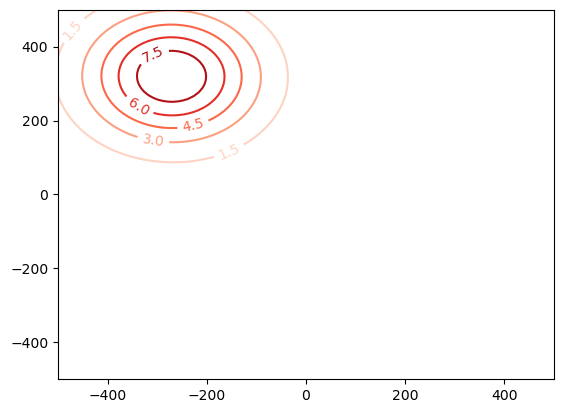

In [28]:
con = plt.contour(xi, yi, zi, cmap='Reds')
plt.clabel(con, inline=True, fontsize=10)



In [ ]:
runpath = '/home/guozx/M31/Output/merge/'
frames = np.arange(0, 510, 10)

# 并行读取数据
results = Parallel(n_jobs=20)(delayed(read)(runpath, i) for i in frames)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

time_values = list(frames/50)
def update(frame):
    posdm_MW,posdm_M31,posMW, posM31,rmw,rm31 = results[frame]
    
    # 清除子图
    for ax in axs.flat:
        ax.clear()
    
    # 绘制 x-y 图

    H, xedges, yedges = create_density_map(np.r_[posdm_MW[:, [0, 1]],posdm_M31[:, [0, 1]]], [-500, 500], [-500, 500])
    axs[0, 0].scatter(rm31[0], rm31[1], s=100, c='r', label='M31')
    axs[0, 0].scatter(rmw[0], rmw[1], s=100, c='b', label='MW')
    axs[0, 0].contour(xedges[:-1], yedges[:-1], np.log10(H), cmap='jet', levels= np.linspace(1.5, 3.5, 10))
    axs[0, 0].set_xlabel('x[kpc]')
    axs[0, 0].set_ylabel('y[kpc]')
    axs[0, 0].legend()
    axs[0, 0].set_xlim(-500, 500)
    axs[0, 0].set_ylim(-500, 500)
    
    # 绘制 x-z 图
    H, xedges, yedges = create_density_map(np.r_[posdm_MW[:, [0, 2]],posdm_M31[:, [0, 2]]], [-500, 500], [-500, 500])
    axs[1, 0].scatter(rm31[0], rm31[2], s=100, c='r', label='M31')
    axs[1, 0].scatter(rmw[0], rmw[2], s=100, c='b', label='MW')
    axs[1, 0].contour(xedges[:-1], yedges[:-1], np.log10(H), cmap='jet', levels= np.linspace(1.5, 3.5, 10))
    axs[1, 0].set_xlabel('x[kpc]')
    axs[1, 0].set_ylabel('z[kpc]')
    axs[1, 0].legend()
    axs[1, 0].set_xlim(-500, 500)
    axs[1, 0].set_ylim(-500, 500)
    
    # 绘制 y-z 图
    H, xedges, yedges = create_density_map(np.r_[posdm_MW[:, [1, 2]],posdm_M31[:, [1, 2]]], [-500, 500], [-500, 500])
    axs[1, 1].scatter(rm31[1], rm31[2], s=100, c='r', label='M31')
    axs[1, 1].scatter(rmw[1], rmw[2], s=100, c='b', label='MW')
    axs[1, 1].contour(xedges[:-1], yedges[:-1], np.log10(H), cmap='jet', levels= np.linspace(1.5, 3.5, 10))
    axs[1, 1].set_xlabel('y[kpc]')
    axs[1, 1].set_ylabel('z[kpc]')
    axs[1, 1].legend()
    axs[1, 1].set_xlim(-500, 500)
    axs[1, 1].set_ylim(-500, 500)
    axs[1, 1].set_title(f't={time_values[frame]:.1f} Gyr')
    

    
ani = FuncAnimation(fig, update, frames=len(frames), repeat=False)

# 保存动画
ani.save('m31_mw_dm.gif', writer=PillowWriter(fps=5))

# 在 Jupyter Notebook 中显示动画
HTML(ani.to_jshtml())

In [ ]:
runpath = '/home/guozx/M31/Output/merge/'
frames = np.arange(0, 10, 10)

# 并行读取数据
results = Parallel(n_jobs=2)(delayed(read)(runpath, i) for i in frames)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

r_values = [np.linalg.norm(result[4]) for result in results]
time_values = list(frames/50)
def update(frame):
    posdm_MW,posdm_M31,posMW, posM31,r = results[frame]
    
    # 清除子图
    for ax in axs.flat:
        ax.clear()
    
    # 绘制 x-y 图
    axs[0, 0].scatter(posMW[:,0], posMW[:,1], s=0.1, c='b', label='MW')
    axs[0, 0].scatter(posM31[:,0], posM31[:,1], s=0.1, c='r', label='M31')
    axs[0, 0].set_xlabel('x[kpc]')
    axs[0, 0].set_ylabel('y[kpc]')
    axs[0, 0].legend()
    axs[0, 0].set_xlim(-500, 500)
    axs[0, 0].set_ylim(-500, 500)
    
    # 绘制 x-z 图
    axs[1, 0].scatter(posMW[:,0], posMW[:,2], s=0.1, c='b', label='MW')
    axs[1, 0].scatter(posM31[:,0], posM31[:,2], s=0.1, c='r', label='M31')
    axs[1, 0].set_xlabel('x[kpc]')
    axs[1, 0].set_ylabel('z[kpc]')
    axs[1, 0].legend()
    axs[1, 0].set_xlim(-500, 500)
    axs[1, 0].set_ylim(-500, 500)
    
    # 绘制 y-z 图
    axs[1, 1].scatter(posMW[:,1], posMW[:,2], s=0.1, c='b', label='MW')
    axs[1, 1].scatter(posM31[:,1], posM31[:,2], s=0.1, c='r', label='M31')
    axs[1, 1].set_xlabel('y[kpc]')
    axs[1, 1].set_ylabel('z[kpc]')
    axs[1, 1].legend()
    axs[1, 1].set_xlim(-500, 500)
    axs[1, 1].set_ylim(-500, 500)
    
    # 绘制 r 随时间变化的图
    axs[0, 1].plot(time_values[:frame+1], r_values[:frame+1], 'g-')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('r')
    axs[0, 1].set_title('r vs Time')
    axs[0, 1].set_xlim(0, 10)
    axs[0, 1].set_ylim(0, 800)
    
ani = FuncAnimation(fig, update, frames=len(frames), repeat=False)

# 保存动画
#ani.save('m31_vs_mw_animation.gif', writer=PillowWriter(fps=5))

# 在 Jupyter Notebook 中显示动画
HTML(ani.to_jshtml())

In [6]:
10**(24.4/5+1)

758577.5750291835